In [1]:
# Thats our five classes
from labeling.emotions import rage, joy, sadness, surprise, fear, all_flag_words

In [2]:
xd = 2500

In [3]:
# and data
with open ('data/all_raw_comments') as f:
    comments = f.read().split('\n')[:xd]

In [4]:
import numpy as np

### Calculate log TF-IDF
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [5]:
words = [word for com_list in [com.split(' ') for com in comments] for word in com_list]

In [6]:
from collections import Counter

In [7]:
word_freq = dict(Counter(words))

In [8]:
# I do not need words which occur in the whole document just once or two
word_freq_filter = {word: freq for word, freq in word_freq.items() if freq > round(xd*0.002) or word in all_flag_words}.keys()

In [9]:
unique_words = word_freq_filter

In [10]:
vocab_size = len(unique_words)

In [11]:
vocab_size

1167

In [12]:
word2int = {}
int2word = {}
for i,word in enumerate(unique_words):
    word2int[word] = i
    int2word[i] = word

In [13]:
comments_tf_idf = []
labels = []

for comment in comments:
    tmp_vec = np.zeros(vocab_size)
    tmp_labels = np.zeros(5)
    
    tmp_word_freq = dict(Counter(comment.split(' ')))
    for word, count in tmp_word_freq.items():
        # for each comment calculate
        
        # label
        for i, emotion in enumerate([rage, joy, sadness, surprise, fear]):
            for flag_word in emotion:
                if word == flag_word:
                    tmp_labels[i] += 1
        
        # and vector with tf-idf features
        if word in word_freq_filter:
            tmp_vec[word2int[word]] = np.log(1 + count / word_freq[word])
    comments_tf_idf.append(tmp_vec)
    # sqrt to soften labels where there was a lot of emotions
    labels.append(np.sqrt(tmp_labels))

In [14]:
del comments

In [15]:
x = np.asarray(comments_tf_idf)
y = np.asarray(labels)

In [16]:
del comments_tf_idf
del labels

In [17]:
print(x.shape, y.shape)

(2500, 1167) (2500, 5)


### Modeling

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.nn import relu

In [19]:
model = Sequential([
    Dense(vocab_size/50, activation=relu, input_shape=[vocab_size]),
    Dense(vocab_size/50, activation=relu),
    Dense(5)
])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
from tensorflow.keras.optimizers import RMSprop

In [21]:
optimizer = RMSprop(0.003)

In [22]:
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=['mean_absolute_error']
)

Instructions for updating:
Use tf.cast instead.


In [23]:
b = int(0.8 * len(x))

In [24]:
train_x = x[:b]
train_y = y[:b]

test_x = x[b:]
test_y = y[b:]

In [25]:
del x
del y

In [26]:
example_batch = test_x[:1]
print(model.predict(example_batch))

[[0. 0. 0. 0. 0.]]


In [27]:
EPOCHS = 150

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=15)

In [30]:
history = model.fit(
    train_x, train_y,
    epochs=EPOCHS, 
    validation_split = 0.2, 
    verbose=0,
    callbacks=[early_stop]
)

Instructions for updating:
Use tf.cast instead.


In [56]:
from datetime import datetime as dt

In [70]:
model.save('models/all_data'+dt.now().date().strftime('%Y_%m_%d'))

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    m = max(max([history.history['mean_absolute_error'] + history.history['val_mean_absolute_error']]))
    plt.ylim([0,m * 1.1])
    plt.legend()

In [33]:
loss, mae = model.evaluate(test_x, test_y, verbose=0)

In [34]:
mae

0.008627166

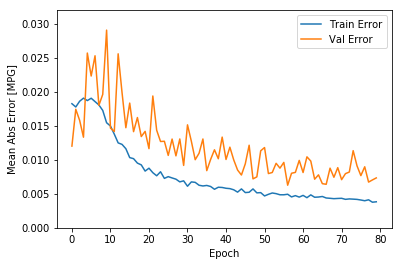

In [35]:
plot_history(history)

In [36]:
pred = model.predict(test_x)

In [37]:
pred = [[p if p > 0.1 else 0 for p in x] for x in pred]

In [38]:
pred = [[p if p < 1 else 1 for p in x] for x in pred]

In [39]:
res = pd.concat([pd.DataFrame(pred), pd.DataFrame(test_y)], axis = 1)

In [40]:
res.columns = ['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5',
               'real_1', 'real_2', 'real_3', 'real_4', 'real_5']

In [41]:
res[res['real_1'] != 0].head(10)

,pred_1,pred_2,pred_3,pred_4,pred_5,real_1,real_2,real_3,real_4,real_5


In [42]:
mae

0.008627166

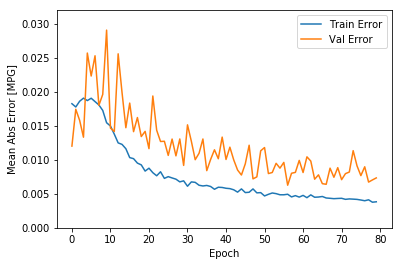

In [43]:
plot_history(history) # /50 /50 #100 batch # RMSprop # 0.003 # more then 3 count